# 4. Example: 4DVar Backprop DA on Lorenz 96

In [1]:
import dabench as dab
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
from scipy.sparse.linalg import aslinearoperator
from copy import deepcopy
import jax.numpy as jnp
from jax import value_and_grad
from IPython.lib.deepreload import reload
import pickle

from ray import train, tune
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

In [2]:
random_seed = 50
np_rng = np.random.default_rng(seed=random_seed)

## A. Create Nature Run

In [3]:
spinup_size = 10000
val_size = 2000
transient_size = 1000
test_size = 2000
system_dim = 36
obs_location_count = round(system_dim/2)
obs_sd = 0.5
sigma_bg = 0.3
sigma_obs = 0.625
delta_t = 0.01
analysis_window = 0.1
analysis_time_in_window = 0.05

In [4]:
# First define data generator and generate data
nature_run = dab.data.Lorenz96(system_dim=system_dim, delta_t=delta_t,
                               store_as_jax=True, random_seed=random_seed)

nature_run.generate(n_steps=(spinup_size + val_size + transient_size + test_size))
nr_spinup, nr_valid, nr_transient_and_test = nature_run.split_train_valid_test(
    spinup_size, val_size, transient_size + test_size)
nr_transient, nr_test, _ = nr_transient_and_test.split_train_valid_test(
    transient_size, test_size, 0)


## B. Define Forecast Model

In [5]:
model_l96 = dab.data.Lorenz96(system_dim=system_dim, delta_t=delta_t, 
                              store_as_jax=True, random_seed=random_seed)

class L96Model(dab.model.Model):                                                                       
    """Defines model wrapper for Lorenz96 to test forecasting."""
    def forecast(self, state_vec, n_steps):
        self.model_obj.generate(x0=state_vec.values, n_steps=n_steps)
        new_vals = self.model_obj.values 

        new_vec = dab.vector.StateVector(values=new_vals, store_as_jax=True)

        return new_vec

fc_model = L96Model(model_obj=model_l96)

## C. Create observer and DA matrices for validation set

In [6]:

# Now we can define the observer:
obs_l96 = dab.observer.Observer(
    nr_valid,
    time_indices = np.arange(0, nr_valid.time_dim, 5),
    random_location_count = obs_location_count,
    error_bias = 0.0,
    error_sd = obs_sd,
    random_seed=random_seed,
    stationary_observers=True,
    store_as_jax=True
)
obs_vec_l96 = obs_l96.observe()

### Set up DA matrices: H (observation), R (obs error), B (background error)
H = np.zeros((obs_location_count, system_dim))
H[np.arange(H.shape[0]), obs_vec_l96.location_indices[0]] = 1
R = (sigma_obs**2)* np.identity(obs_location_count)
B = (sigma_bg**2)*np.identity(system_dim)

## D. RayTune to find learning rate and learning rate decay

In [7]:
def run_4dvar_backprop(lr_config):
    learning_rate = lr_config['learning_rate']
    lr_decay = lr_config['lr_decay']
    # Prep DA object
    dc = dab.dacycler.Var4DBackprop(
        system_dim=system_dim,
        delta_t=nr_valid.delta_t,
        H=H,
        B=B,
        R=R,
        learning_rate=learning_rate,
        lr_decay=lr_decay,
        model_obj=fc_model,
        obs_window_indices=[0,5,10],
        steps_per_window=11, # 11 instead of 10 because inclusive of 0 and 11
        )

    # Generate initial conditions
    cur_tstep = 0
    x0_original = nr_valid.values[cur_tstep] + np_rng.normal(size=(system_dim,), 
                                                            scale=1)
    x0_sv = dab.vector.StateVector(
        values=x0_original,
        store_as_jax=True)
    
    # Execute
    out_statevec = dc.cycle(
        input_state = x0_sv,
        start_time = nr_valid.times[cur_tstep],
        obs_vector = obs_vec_l96,
        analysis_window=analysis_window,
        timesteps=198,
        obs_error_sd=sigma_obs,
        analysis_time_in_window=analysis_time_in_window)
    
    rmse = np.sqrt(np.mean(np.square(nr_valid.values[:-20] - out_statevec.values)))

    train.report({'rmse':rmse})

In [8]:
# Define search space
space = {
    "learning_rate": hp.loguniform("lr", -10, 0),
    "lr_decay": hp.uniform("lr_decay", 0.1, 0.99),
}

hyperopt_search = HyperOptSearch(space, metric="rmse", mode="min",
                                 random_state_seed=random_seed)
tuner = tune.Tuner(
    run_4dvar_backprop,
    tune_config=tune.TuneConfig(
        num_samples=50,
        max_concurrent_trials=4,
        search_alg=hyperopt_search,
    ),
)

results = tuner.fit()
results_df = results.get_dataframe()

(run_4dvar_backprop pid=364509) [[ 212.24441381  193.44530609  182.1444591 ]
(run_4dvar_backprop pid=364509)  [ 137.91540358  124.38460394  116.40619026]
(run_4dvar_backprop pid=364509)  [ 129.68746223  115.46940132  107.2593762 ]
(run_4dvar_backprop pid=364509)  [ 125.41164351  113.41228566  106.4055783 ]
(run_4dvar_backprop pid=364509)  [ 116.22258715  105.53299468   99.29575076]
(run_4dvar_backprop pid=364509)  [ 158.59490042  143.3580394   134.4330919 ]
(run_4dvar_backprop pid=364509)  [ 219.1506353   194.6802734   180.38363762]
(run_4dvar_backprop pid=364509)  [ 322.83942719  284.80713494  262.70131475]
(run_4dvar_backprop pid=364509)  [ 381.44983115  337.7797882   312.10560162]
(run_4dvar_backprop pid=364509)  [ 267.38406391  240.893464    225.05426821]
(run_4dvar_backprop pid=364509)  [ 230.26923815  206.49169772  192.54667637]
(run_4dvar_backprop pid=364509)  [ 262.81789771  234.42115972  217.8287479 ]
(run_4dvar_backprop pid=364509)  [ 245.82255689  221.48625334  206.99816542]

2024-06-24 09:55:42,386	ERROR tune_controller.py:1331 -- Trial task failed for trial run_4dvar_backprop_4ddcc574
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/ray/_private/worker.py", line 2630, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  

(run_4dvar_backprop pid=369434) [[212.24441381 167.95938454 159.70694968]
(run_4dvar_backprop pid=369434)  [116.00726587  90.12619193  85.63385937]
(run_4dvar_backprop pid=369434)  [103.44046936  83.83255804  80.5047237 ]
(run_4dvar_backprop pid=369434)  [126.49204746  95.02407416  89.80097111]
(run_4dvar_backprop pid=369434)  [159.81499232 119.51062034 112.91460764]
(run_4dvar_backprop pid=369434)  [185.99866584 136.54721582 128.44330245]
(run_4dvar_backprop pid=369434)  [112.41635572  85.56902036  81.01061535]
(run_4dvar_backprop pid=369434)  [106.31077698  82.11135849  78.27843604]
(run_4dvar_backprop pid=369434)  [106.73204597  86.09604588  82.52567134]
(run_4dvar_backprop pid=369434)  [110.62792254  91.2199275   87.64257694]
(run_4dvar_backprop pid=369434)  [133.51099307 105.36690048 100.28793873]
(run_4dvar_backprop pid=369434)  [100.06463848  83.7932508   80.58302783]
(run_4dvar_backprop pid=369434)  [114.33852237  87.01019173  83.40104971]
(run_4dvar_backprop pid=369434)  [105.

2024-06-24 09:57:17,772	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/ksolvik/ray_results/run_4dvar_backprop_2024-06-24_09-52-31' in 0.1163s.
2024-06-24 09:57:17,792	ERROR tune.py:1037 -- Trials did not complete: [run_4dvar_backprop_4ddcc574]
2024-06-24 09:57:17,794	INFO tune.py:1041 -- Total run time: 281.41 seconds (281.21 seconds for the tuning loop).


## E. Running DA Cycler on test set

In [9]:
results_df = results.get_dataframe()

In [10]:
best_result = results_df.loc[results_df['rmse'].idxmin()]
print('Validation RMSE: {}'.format(best_result['rmse']))

Validation RMSE: 0.3231729807664304


In [11]:
best_lr = best_result['config/learning_rate']
best_lr_decay = best_result['config/lr_decay']

In [12]:

# Observations on test set
obs_l96_test = dab.observer.Observer(
    nr_test,
    time_indices = np.arange(0, nr_test.time_dim, 5),
    random_location_count = obs_location_count,
    error_bias = 0.0,
    error_sd = obs_sd,
    random_seed=random_seed,
    stationary_observers=True,
    store_as_jax=True
)
obs_vec_l96_test = obs_l96_test.observe()

# Set up DA matrices: H (observation), R (obs error), B (background error)
H = np.zeros((obs_location_count, system_dim))
H[np.arange(H.shape[0]), obs_vec_l96_test.location_indices[0]] = 1
R = (sigma_obs**2)* np.identity(obs_location_count)
B = (sigma_bg**2)*np.identity(system_dim)

# Prep DA object
dc = dab.dacycler.Var4DBackprop(
    system_dim=system_dim,
    delta_t=nr_test.delta_t,
    H=H,
    B=B,
    R=R,
    learning_rate=best_lr,
    lr_decay=best_lr_decay,
    model_obj=fc_model,
    obs_window_indices=[0,5,10],
    steps_per_window=11, # 11 instead of 10 because inclusive of 0 and 11
    )

# Generate initial conditions
cur_tstep = 0
x0_original = nr_test.values[cur_tstep] + np_rng.normal(size=(system_dim,), 
                                                        scale=1)
x0_sv = dab.vector.StateVector(
    values=x0_original,
    store_as_jax=True)
    
# Execute
out_statevec = dc.cycle(
    input_state = x0_sv,
    start_time = nr_test.times[cur_tstep],
    obs_vector = obs_vec_l96_test,
    analysis_window=analysis_window,
    timesteps=198,
    obs_error_sd=sigma_obs,
    analysis_time_in_window=analysis_time_in_window)

rmse = np.sqrt(np.mean(np.square(nr_test.values[:-20] - out_statevec.values)))

[[250.01549567 201.13407816 177.89468739]
 [ 76.38971157  70.01337439  62.50510526]
 [ 60.91588341  52.80286829  48.12458592]
 [ 64.63290084  56.47612384  52.26871823]
 [ 89.39676917  77.2550956   70.67139437]
 [118.14552992  98.13977695  92.15489096]
 [225.64373065 173.05798089 156.49644404]
 [284.1451267  215.59483583 191.05382784]
 [209.52663213 163.56387372 149.13783002]
 [ 94.39597824  74.21304859  68.22122071]
 [ 51.36522579  43.78073138  41.36368907]
 [ 46.9704508   43.43654456  42.16744127]
 [ 40.89282841  37.1169029   35.65644474]
 [ 61.78936665  53.75039514  50.2989395 ]
 [ 79.40525431  65.1595918   58.90033452]
 [ 86.31492725  71.19234663  63.94403897]
 [ 51.94837254  43.87634855  41.54404095]
 [ 47.04795438  40.27522609  38.06523839]
 [ 41.46073177  37.45263209  35.75777402]
 [ 50.31925895  45.45885422  42.70447089]
 [ 49.22116106  42.37628805  39.15120506]
 [ 31.90728366  28.48575277  27.4704737 ]
 [ 45.77429957  41.63008623  39.66518249]
 [ 46.10436148  41.59047631  39.82

In [13]:
print('Test RMSE = {}'.format(rmse))

Test RMSE = 0.3958682974093788


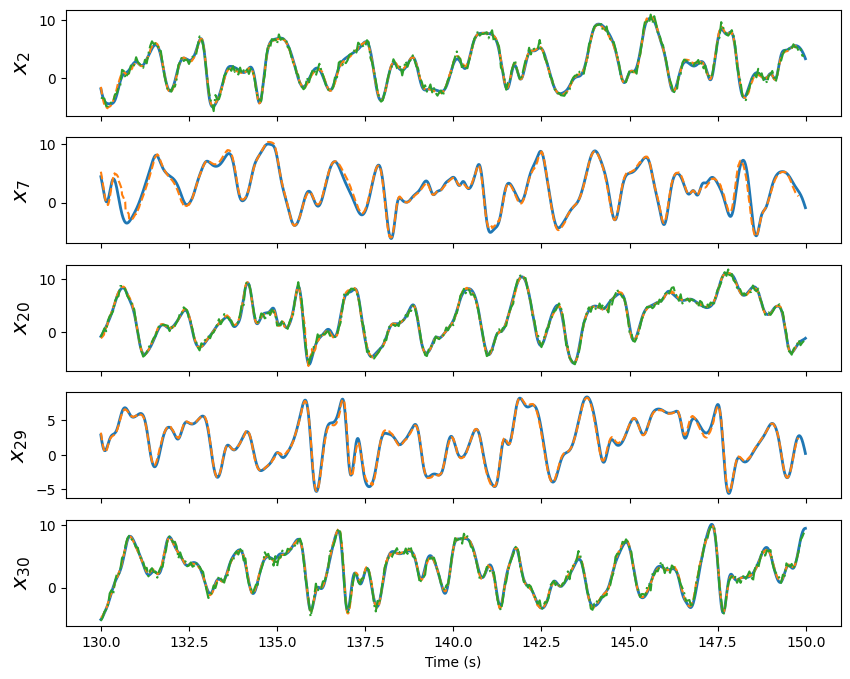

In [14]:
# Plot them all
example_indices = np.sort(np_rng.choice(np.arange(system_dim),5, replace=False))
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 8))
for i, ax in enumerate(axes):
    j = example_indices[i]
    ax.plot(nr_test.times, nr_test.values[:, j], label='Nature Run', lw=2)
    ax.plot(nr_test.times[:out_statevec.time_dim], out_statevec.values[:, j],
        label='DA', ls='--', lw=1.5)
    if j in obs_vec_l96.location_indices[0]:
        ax.plot(obs_vec_l96_test.times, obs_vec_l96_test.values[:, obs_vec_l96.location_indices[0]==j],
                label='Observations', lw=1.5, ls='-.')
    ax.set_ylabel(r'$x_{{{:d}}}$'.format(j), fontsize = 16)
    if j ==0:
        ax.legend()
ax.set_xlabel('Time (s)')        
plt.show()